# Project setup

Before we do any machine learning we are going to have to setup our project by performing the necessary imports and using the right hardware



In [130]:
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


We will be using Google Colab's available GPUs to speed up our training and compile times:

In [131]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Our data has been uploaded to Google Drive so we need to get it from there and unzip it to be able to use it:

In [132]:
drive.mount('/content/drive')
!unzip -uq "/content/drive/MyDrive/Machine Learning/zoidberg-2.0/data.zip" -d "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


As a general rule of thumb we'll define our project configuration as a series of constant insteads of using hard-coded values in our code.

In [133]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
DATA_DIR = '/content/data/'
EPOCHS = 10
IMAGE_SIZE = (150, 150)
INPUT_SHAPE = (150, 150, 3)
LABELS = ['NORMAL', 'PNEUMONIA']
OPTIMIZER = 'sgd'
VERBOSE = True

# Loading the data
The Chest X-Ray day recieved in the dataset has already been split into threee sub-categories train, validation and test. There is a relatively large imbalance in the quantity of data between the training and validation sets, so we'll merge the data sets and split them again using a more reasonable split ratio of 80:20 or 4:1.

First we will create a list of all the file paths in both the training and validation sets:

In [134]:
train_data_dir = os.path.join(DATA_DIR, 'train/*/[!.]*') # Ingore any hidden files
validation_data_dir = os.path.join(DATA_DIR, 'validation/*/[!.]*') # Ignore any hidden files

files = tf.io.gfile.glob(train_data_dir)
files.extend(tf.io.gfile.glob(validation_data_dir))

Now we need to split the data using the ratio we previously stated and load them in as datasets:


In [135]:
train_files, validation_files = train_test_split(files, test_size=0.2)

TRAIN_COUNT_NORMAL = len([filename for filename in train_files if "/NORMAL/" in filename])
TRAIN_COUNT_BACTERIA = len([filename for filename in train_files if "/BACTERIA/" in filename])
TRAIN_COUNT_VIRUS = len([filename for filename in train_files if "/VIRUS/" in filename])

TRAIN_COUNT_PNEUMONIA = TRAIN_COUNT_BACTERIA + TRAIN_COUNT_VIRUS

VAL_COUNT_NORMAL = len([filename for filename in validation_files if "/NORMAL/" in filename])
VAL_COUNT_BACTERIA = len([filename for filename in validation_files if "/BACTERIA/" in filename])
VAL_COUNT_VIRUS = len([filename for filename in validation_files if "/VIRUS/" in filename])

VAL_COUNT_PNEUMONIA = VAL_COUNT_BACTERIA + VAL_COUNT_VIRUS

ds_train = tf.data.Dataset.from_tensor_slices(train_files)
ds_validation = tf.data.Dataset.from_tensor_slices(validation_files)

print("Number of normal cases in the train dataset: " + str(TRAIN_COUNT_NORMAL))
print("Number of pneumonia cases in the train dataset: " + str(TRAIN_COUNT_PNEUMONIA))

print("Number of normal cases in the validation dataset: " + str(VAL_COUNT_NORMAL))
print("Number of pneumonia cases in the validation dataset: " + str(VAL_COUNT_PNEUMONIA))

Number of normal cases in the train dataset: 1078
Number of pneumonia cases in the train dataset: 3107
Number of normal cases in the validation dataset: 271
Number of pneumonia cases in the validation dataset: 776


Up to this point our data set only consists of file paths but to be able to effectively train our models we are going to need a list of image and label pairs.

In [136]:
def decode_img(img_path):

    # Load the raw data from the file as a string tensor
    img = tf.io.read_file(img_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0, 1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    img = tf.image.resize(img, IMAGE_SIZE)

    return img

def get_img_label(img_path):
    # Split the file path into a list of path components
    parts = tf.strings.split(img_path, os.path.sep)
    # The second to last component should be class/label of the image
    class_name = parts[-2]

    # Encode labels as positive(pneumonia) or negative(normal)
    if (class_name == "NORMAL"):
        return False
    else:
        return True

def process_path(img_path):
    label = get_img_label(img_path)
    img = decode_img(img_path)
    return img, label


# Get images and labels
ds_train = ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
ds_validation = ds_validation.map(process_path, num_parallel_calls=AUTOTUNE)

# Getting a count of the records in the datasets
TRAIN_COUNT = tf.data.experimental.cardinality(ds_train).numpy()
VALIDATION_COUNT = tf.data.experimental.cardinality(ds_validation).numpy()

# Ensuring the data has been split correctly
print("Number of training samples: " + str(TRAIN_COUNT))
print("Number of validation samples: " + str(VALIDATION_COUNT))

Number of training samples: 4185
Number of validation samples: 1047


Now that all the training and validation data has been correctly loaded we also need to load in out test data for evaluation at the end.

In [137]:
test_files = tf.data.Dataset.list_files(str(DATA_DIR + '/test/*/[!.]*'))
ds_test = test_files.map(process_path, num_parallel_calls=AUTOTUNE)
TEST_COUNT = tf.data.experimental.cardinality(ds_test).numpy()

ds_test = ds_test.batch(BATCH_SIZE)

TEST_COUNT

624

## Data augmentation

The success of image classification is driven, at least significantly, by large amounts of available training data. Putting aside concerns such as overfitting for a moment, the more image data you train with, the better chances you have of building an effective model.

In our case we don't have that luck and have very few instances of each class. But what can we do when we don't have a substantial amount of training data? One approch we can put in place to possibly improve the outcome is data augmentation.

First let's define out data augmentation functions:

In [138]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))


def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """

    # Randomly flip image left or right
    x = tf.image.random_flip_left_right(x)
    # Randomly flip image up or down
    x = tf.image.random_flip_up_down(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    # x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=IMAGE_SIZE)
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

Now that our functions have been defined we apply them to our exisiting data to create "new" data.


In [139]:
augmentations = [color, zoom]

def augment_dataset(dataset, augmentations, factor):
    """Performs augmentations on a dataset

    Args:
        dataset: Original dataset to augment
        augmentations: List of augmentation functions
        factor: number of times to augment the data 

    Returns:
        Augmented dataset
    """
    result = None
    for idx in range(factor - 1):
        for f in augmentations:
            ds_augmented = dataset.map(lambda x, y: (f(x), y), num_parallel_calls=AUTOTUNE)

        # Regularize values that modified beyond an accepted range
        ds_augmented = ds_augmented.map(lambda x, y: (tf.clip_by_value(x, 0, 1), y))
        if result is None:
            result = ds_augmented
        else:
            result = result.concatenate(ds_augmented)

    return result

aug_factor = 3

augmented_train = augment_dataset(ds_train, augmentations, aug_factor)
augmented_validation = augment_dataset(ds_validation, augmentations, aug_factor)

All that's left to do is add this data to our original dataset:

In [140]:
# Add the augmented data to the original datasets 
ds_train = ds_train.concatenate(augmented_train)
ds_validation = ds_validation.concatenate(augmented_validation)

# Recount the datasets
TRAIN_COUNT = TRAIN_COUNT * aug_factor
VALIDATION_COUNT = VALIDATION_COUNT * aug_factor 

# Increase the category counts by the augmentation factor
TRAIN_COUNT_NORMAL = TRAIN_COUNT_NORMAL * aug_factor
TRAIN_COUNT_PNEUMONIA = TRAIN_COUNT_PNEUMONIA * aug_factor

print("New number of training samples: " + str(TRAIN_COUNT))
print("New number of validation samples: " + str(VALIDATION_COUNT))

print("New umber of normal cases: " + str(TRAIN_COUNT_NORMAL))
print("New number of pneumonia cases: " + str(TRAIN_COUNT_PNEUMONIA))

New number of training samples: 12555
New number of validation samples: 3141
New umber of normal cases: 3234
New number of pneumonia cases: 9321


## Configuring the data for performance


In [141]:
def configure_for_performance(ds, shuffle_buffer_size=1000):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


ds_train = configure_for_performance(ds_train)
ds_validation = configure_for_performance(ds_validation)

## Visualizing the data

It's always a good idea to have a visualization of your data beforehand. Let's get a quick glance at our first batch:

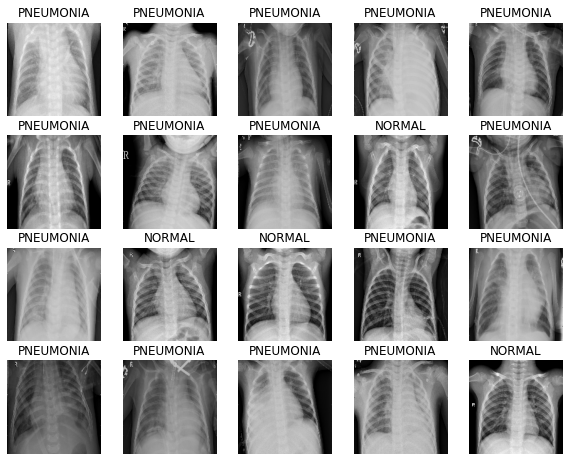

In [142]:
def plot_images(image_batch, label_batch=None, num_samples=10):
    plt.figure(figsize=(10, 10))
    for n in range(num_samples):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])

        # Add labels if given
        if label_batch is not None:
            plt.title(LABELS[label_batch[n]])
        plt.axis("off")

image_batch, label_batch = next(iter(ds_train))
plot_images(image_batch.numpy(), label_batch, num_samples=20)

# Building our model

For this project we will be building a simple Convolutional Neural Network to classify our images.

In [143]:
def create_model():
    model = Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(units=128, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(units=64, activation='relu'),
        layers.Dropout(rate=0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return model


# Training the model

For this example we will be categorizing the images into two groups: normal and pneumonia. Since this is the case we will be using binary categorical crossentropy as our loss function. 

For our metri
cs, we want to include precision and recall along with the accuracy as they will provide us with a more informed picture of how good our model is:

* Accuracy tells us the ratio of number of correct predictions to the total number of input samples. It is generally a good metric to begin with but doesn’t always tell the full story. It works well when the dataset is balanced but isn’t so useful when it isn’t. For example, consider that there are 98% samples of class A and 2% samples of class B in our training set. Then our model can easily get 98% training accuracy by simply predicting every training sample belonging to class A.  

* Precision is the number of correct positive results divided by the number of positive results predicted by the classifier. It is mainly useful in helping us to identify what percentage of our predictions were falsely classified as being cases of pneumonia.

* Recall is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive). This helped us to identify what percentage of actual pneumonia cases were correctly classified.

In [144]:
with tf.device('/device:GPU:0'):
    model = create_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS
    )

    history = model.fit(
        ds_train,
        epochs=10,
        validation_data=ds_validation
    )


Epoch 1/10
393/393 [==============================] - 107s 255ms/step - loss: 0.5667 - accuracy: 0.7278 - precision: 0.7469 - recall: 0.9555 - val_loss: 0.4888 - val_accuracy: 0.7654 - val_precision: 0.9920 - val_recall: 0.6890
Epoch 2/10
393/393 [==============================] - 9s 22ms/step - loss: 0.3696 - accuracy: 0.8077 - precision: 0.8176 - recall: 0.9542 - val_loss: 0.2382 - val_accuracy: 0.9134 - val_precision: 0.9203 - val_recall: 0.9669
Epoch 3/10
393/393 [==============================] - 9s 22ms/step - loss: 0.2717 - accuracy: 0.8986 - precision: 0.9190 - recall: 0.9474 - val_loss: 0.2354 - val_accuracy: 0.9074 - val_precision: 0.9731 - val_recall: 0.8999
Epoch 4/10
393/393 [==============================] - 9s 22ms/step - loss: 0.2339 - accuracy: 0.9184 - precision: 0.9421 - recall: 0.9482 - val_loss: 0.1978 - val_accuracy: 0.9306 - val_precision: 0.9317 - val_recall: 0.9781
Epoch 5/10
393/393 [==============================] - 9s 22ms/step - loss: 0.2244 - accuracy: 0.9

# Visualizing the training results

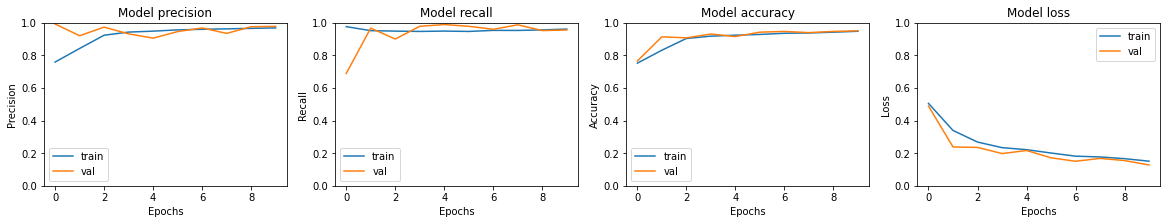

In [145]:
fig, axis= plt.subplots(1, 4, figsize=(20, 3))
axis = axis.ravel()

for idx, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    axis[idx].plot(history.history[metric])
    axis[idx].plot(history.history['val_' + metric])
    axis[idx].set_title('Model {}'.format(metric))
    axis[idx].set_xlabel('Epochs')
    axis[idx].set_ylabel(metric.capitalize())
    axis[idx].legend(['train', 'val'])
    axis[idx].set_ylim([0, 1.0])


# Testing the model

Now that our model has been train, it's time to try it out on data it hasn't seen before to find out how well it generalizes.

In [146]:
loss, acc, prec, rec = model.evaluate(ds_test)

20/20 [==============================] - 3s 147ms/step - loss: 0.5251 - accuracy: 0.8381 - precision: 0.8162 - recall: 0.9564


Here we can see that we have attained an accuracy that is less that what we attained during the training phase. This generally indicated overfitting is some shape or form.

Another thing we can look at is our precision with respect to our recall. Our recall is significantly higher than our precision which indicates that some normal cases are being classified as pneumonia. This may due to imbalance in the dataset or a lack of fine-tuning.

In this state our data might be difficult to understand so let's try displaying it differently to make it clearer. First lets show some examples of predictions:

Total number of test samples: 624


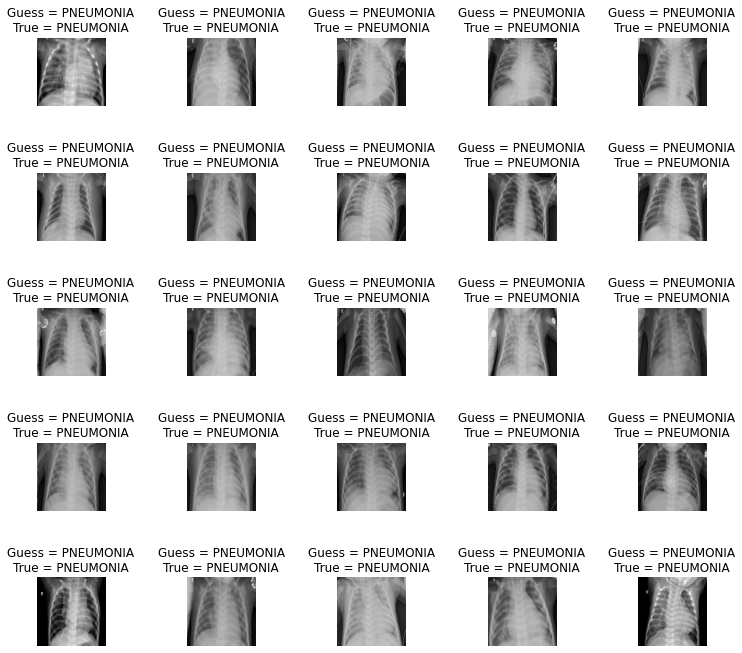

In [147]:
images = []
prediction_labels = []
true_labels = []

test_dir = os.path.join(DATA_DIR, 'test/*/[!.]*')
test_files = tf.io.gfile.glob(test_dir)

print("Total number of test samples: " + str(len(test_files)))
for idx in range(len(test_files)):
    img = cv2.imread(test_files[idx])
    img = cv2.resize(img, IMAGE_SIZE)
    img = img.astype('float32') / 255
    images.append(img)
    # Get original label
    parts = test_files[idx].split(os.path.sep)
    class_name = parts[-2]
    if (class_name == "NORMAL"):
        true_labels.append(0)
    else:
        true_labels.append(1)

predictions = model.predict(np.asarray(images))

fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    pred_idx = np.round(predictions[i][0]).astype('int')
    axes[i].set_title('Guess = {}\nTrue = {}'.format(LABELS[pred_idx], LABELS[true_labels[i]]))

plt.subplots_adjust(wspace = 1.2)

While this may be pretty for demonstration it does not tell the full story. Let's generate a simple classification report of our model:

In [148]:
print("Classification Report\n\n")
print(classification_report(true_labels, np.round(predictions)))

Classification Report


              precision    recall  f1-score   support

           0       0.90      0.64      0.74       234
           1       0.81      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.81       624
weighted avg       0.85      0.84      0.83       624



Now lets display a confusion matrix of our test:

Text(51.0, 0.5, 'Original')

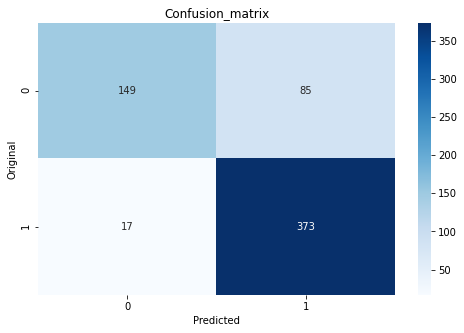

In [149]:
conf_mat = confusion_matrix(true_labels, np.round(predictions))

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(5)
ax = plt.subplot()
sns.heatmap(conf_mat, annot=True, ax=ax, cmap='Blues', fmt='g')

ax.set_title('Confusion_matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Original')

From this confusion matrix we can see that for the most part we are classifying the images correctly. But as we started earlier there is a clear bias towards classifying patients as having pneumonia when they don't. In the case of this experiment however, the result is acceptable. It's better to classify someone as having pneumonia when they don't rather than saying they don't have it and they do.